In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import torch

In [2]:
CLICK_PATH = 'Data/clicks/'

click_files = [CLICK_PATH + f for f in os.listdir(CLICK_PATH)]

click_files.sort()

print("Number of click files: ", len(click_files))

print("Concatenating click files...")

click_dfs = [pd.read_csv(x) for x in click_files]

click_df = pd.concat(click_dfs, axis=0, ignore_index=True)

print(click_df.shape)
click_df.head()

Number of click files:  385
Concatenating click files...
(2988181, 12)


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [3]:
click_df = click_df.astype('int')
click_df.describe()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
count,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06,2.988181e+06
mean,1.079478e+05,1.507472e+15,1.507472e+12,3.901885e+00,1.949226e+05,1.507474e+12,3.942652e+00,1.819306e+00,1.327760e+01,1.357656e+00,1.831331e+01,1.838981e+00
std,8.364836e+04,3.855245e+11,3.855245e+08,3.929941e+00,9.076842e+04,3.858510e+08,3.396804e-01,1.042214e+00,6.881718e+00,1.725861e+00,7.064006e+00,1.156356e+00
min,0.000000e+00,1.506825e+15,1.506825e+12,2.000000e+00,3.000000e+00,1.506827e+12,1.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,4.034100e+04,1.507124e+15,1.507124e+12,2.000000e+00,1.242280e+05,1.507127e+12,4.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.300000e+01,1.000000e+00
50%,8.622900e+04,1.507493e+15,1.507493e+12,3.000000e+00,2.023810e+05,1.507495e+12,4.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.100000e+01,2.000000e+00
75%,1.632610e+05,1.507749e+15,1.507749e+12,4.000000e+00,2.770670e+05,1.507751e+12,4.000000e+00,3.000000e+00,1.700000e+01,1.000000e+00,2.500000e+01,2.000000e+00
max,3.228960e+05,1.508211e+15,1.508211e+12,1.240000e+02,3.640460e+05,1.510603e+12,4.000000e+00,5.000000e+00,2.000000e+01,1.100000e+01,2.800000e+01,7.000000e+00


In [4]:
# Hashing article ids to prevent duplicates between user_id and click_article_id
article_ids = click_df.click_article_id.unique()
article_hashs = pd.util.hash_array(article_ids)

index_to_hash = dict(zip(article_ids, article_hashs))
hash_to_index = dict(zip(article_hashs, article_ids))

len(hash_to_index)

46033

In [5]:
click_df['article_id'] = click_df['click_article_id'].apply(lambda x: index_to_hash[x])
click_df.drop(columns='click_article_id', inplace=True)
click_df.head()

,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id
0,0,1506825423271737,1506825423000,2,1506826828020,4,3,20,1,20,2,11291614159970095935
1,0,1506825423271737,1506825423000,2,1506826858020,4,3,20,1,20,2,1808725759962028682
2,1,1506825426267738,1506825426000,2,1506827017951,4,1,17,1,16,2,8060067950874265602
3,1,1506825426267738,1506825426000,2,1506827047951,4,1,17,1,16,2,8467875143793121792
4,2,1506825435299739,1506825435000,2,1506827090575,4,1,17,1,24,2,3839974878073404050


In [31]:
click_df

,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id
0,0,1506825423271737,1506825423000,2,1506826828020,4,3,20,1,20,2,11291614159970095935
1,0,1506825423271737,1506825423000,2,1506826858020,4,3,20,1,20,2,1808725759962028682
2,1,1506825426267738,1506825426000,2,1506827017951,4,1,17,1,16,2,8060067950874265602
3,1,1506825426267738,1506825426000,2,1506827047951,4,1,17,1,16,2,8467875143793121792
4,2,1506825435299739,1506825435000,2,1506827090575,4,1,17,1,24,2,3839974878073404050
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,1508211557302,4,3,2,1,25,1,9145846767463514897
2988177,322896,1508211376302329,1508211376000,2,1508211672520,4,1,17,1,25,2,11966379547785623297
2988178,322896,1508211376302329,1508211376000,2,1508211702520,4,1,17,1,25,2,17035819092917373661
2988179,123718,1508211379189330,1508211379000,2,1508211513583,4,3,2,1,25,2,13284560895759463907


In [32]:
click_df.drop_duplicates()

,user_id,session_id,session_start,session_size,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type,article_id
0,0,1506825423271737,1506825423000,2,1506826828020,4,3,20,1,20,2,11291614159970095935
1,0,1506825423271737,1506825423000,2,1506826858020,4,3,20,1,20,2,1808725759962028682
2,1,1506825426267738,1506825426000,2,1506827017951,4,1,17,1,16,2,8060067950874265602
3,1,1506825426267738,1506825426000,2,1506827047951,4,1,17,1,16,2,8467875143793121792
4,2,1506825435299739,1506825435000,2,1506827090575,4,1,17,1,24,2,3839974878073404050
...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,10051,1508211372158328,1508211372000,2,1508211557302,4,3,2,1,25,1,9145846767463514897
2988177,322896,1508211376302329,1508211376000,2,1508211672520,4,1,17,1,25,2,11966379547785623297
2988178,322896,1508211376302329,1508211376000,2,1508211702520,4,1,17,1,25,2,17035819092917373661
2988179,123718,1508211379189330,1508211379000,2,1508211513583,4,3,2,1,25,2,13284560895759463907


In [6]:
#Generating user information:
users = click_df.groupby('user_id').agg(clicks = ('session_id', pd.Series.count), avg_session_size = ('session_size', np.mean),
                                        env = ('click_environment', st.mode), device = ('click_deviceGroup', st.mode),
                                        os = ('click_os', st.mode), region = ('click_region', st.mode),
                                        ref_type = ('click_referrer_type', st.mode), sessions = ('session_id', pd.Series.nunique))
users

,clicks,avg_session_size,env,device,os,region,ref_type,sessions
user_id,,,,,,,,
0,8,2.000000,4,3,20,20,2,4
1,12,2.000000,4,1,17,17,2,6
2,4,2.000000,4,1,17,24,2,2
3,17,3.117647,4,3,2,21,1,6
4,7,2.428571,4,1,17,17,1,3
...,...,...,...,...,...,...,...,...
322892,2,2.000000,4,1,12,16,1,1
322893,2,2.000000,4,3,2,25,2,1
322894,2,2.000000,4,3,20,25,2,1


In [7]:
cf_matrix = click_df[['user_id','article_id','session_id']].groupby(['user_id','article_id']).count().reset_index()
cf_matrix.rename(columns={'session_id': 'clicks'}, inplace=True)
cf_matrix.head()

,user_id,article_id,clicks
0,0,453242478275739747,1
1,0,1808725759962028682,1
2,0,2329946091212022948,1
3,0,2743957319142419568,1
4,0,3354362278157922163,1


In [8]:
cf_matrix['clicks'].value_counts()

1     2916835
2       31459
3        1869
4         343
5          95
6          42
7          22
8          14
9           7
10          7
13          6
12          3
33          3
16          2
17          1
30          1
31          1
Name: clicks, dtype: int64

In [9]:
# User click matrix that will be used because Pinsage requires a timestamp
clicks = click_df[['user_id','article_id','click_timestamp']]
clicks.rename(columns={'click_timestamp': 'timestamp'}, inplace=True)
clicks

/tmp/ipykernel_1555/2569374984.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clicks.rename(columns={'click_timestamp': 'timestamp'}, inplace=True)


,user_id,article_id,timestamp
0,0,11291614159970095935,1506826828020
1,0,1808725759962028682,1506826858020
2,1,8060067950874265602,1506827017951
3,1,8467875143793121792,1506827047951
4,2,3839974878073404050,1506827090575
...,...,...,...
2988176,10051,9145846767463514897,1508211557302
2988177,322896,11966379547785623297,1508211672520
2988178,322896,17035819092917373661,1508211702520
2988179,123718,13284560895759463907,1508211513583


In [10]:
article_embeddings = pd.read_pickle('Data/articles_embeddings.pickle')
article_embeddings = pd.DataFrame(article_embeddings)
article_embeddings

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
0,-0.161183,-0.957233,-0.137944,0.050855,0.830055,0.901365,-0.335148,-0.559561,-0.500603,0.165183,...,0.321248,0.313999,0.636412,0.169179,0.540524,-0.813182,0.286870,-0.231686,0.597416,0.409623
1,-0.523216,-0.974058,0.738608,0.155234,0.626294,0.485297,-0.715657,-0.897996,-0.359747,0.398246,...,-0.487843,0.823124,0.412688,-0.338654,0.320787,0.588643,-0.594137,0.182828,0.397090,-0.834364
2,-0.619619,-0.972960,-0.207360,-0.128861,0.044748,-0.387535,-0.730477,-0.066126,-0.754899,-0.242004,...,0.454756,0.473184,0.377866,-0.863887,-0.383365,0.137721,-0.810877,-0.447580,0.805932,-0.285284
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
4,-0.279052,-0.972315,0.685374,0.113056,0.238315,0.271913,-0.568816,0.341194,-0.600554,-0.125644,...,0.238286,0.809268,0.427521,-0.615932,-0.503697,0.614450,-0.917760,-0.424061,0.185484,-0.580292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364042,-0.055038,-0.962136,0.869436,-0.071523,-0.725294,0.434320,0.198312,-0.581154,0.702346,-0.124813,...,-0.410549,0.564252,-0.463959,0.167907,-0.480068,0.652090,0.380880,0.433195,-0.662455,-0.222850
364043,-0.136932,-0.995471,0.991298,0.031871,-0.915622,-0.658517,0.633090,-0.564356,0.676551,-0.446068,...,-0.681986,-0.574185,-0.536908,0.688934,0.528204,0.162435,0.940364,0.989298,-0.761595,-0.414652
364044,-0.251390,-0.976243,0.586097,0.643631,-0.663359,-0.093480,0.691553,-0.588281,0.902999,0.124571,...,-0.162220,-0.242030,-0.476131,0.352132,-0.311279,0.460574,-0.653077,-0.143725,0.068093,-0.705010
364045,0.224342,-0.923288,-0.381742,0.687890,-0.773911,-0.103629,-0.406486,0.246004,0.255191,-0.329587,...,-0.422999,0.390324,0.655911,-0.646753,-0.174031,0.698037,-0.317102,0.687132,-0.531512,0.010726


In [11]:
# Removing articles that have never been viewed
article_embeddings = article_embeddings.loc[np.isin(article_embeddings.index, article_ids)]
article_embeddings.index.names=['article_id']
article_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
article_id,,,,,,,,,,,,,,,,,,,,,
3,-0.740843,-0.975749,0.391698,0.641738,-0.268645,0.191745,-0.825593,-0.710591,-0.040099,-0.110514,...,0.271535,0.036040,0.480029,-0.763173,0.022627,0.565165,-0.910286,-0.537838,0.243541,-0.885329
27,-0.700814,-0.965927,-0.181869,-0.423504,-0.024668,0.187061,-0.674657,-0.108778,-0.762116,0.161282,...,0.165887,0.694188,0.495848,-0.629343,-0.231966,0.564555,-0.762103,-0.388876,0.696865,-0.532873
69,0.093521,-0.981410,0.848944,0.530125,0.767768,0.067014,-0.764069,-0.238016,-0.504944,-0.215097,...,0.413857,-0.261328,-0.361129,-0.228905,-0.815412,-0.150129,-0.309511,-0.877652,0.643542,-0.908095
81,0.221564,-0.978803,0.614596,-0.049789,0.159638,-0.029031,-0.716393,-0.287863,-0.622962,-0.040135,...,0.413513,0.150322,0.073361,-0.152517,-0.645792,0.680978,-0.519698,-0.248209,0.717366,-0.816945
84,-0.497972,-0.976125,0.812216,-0.591446,0.876975,0.338400,-0.701809,-0.711910,-0.168073,-0.162825,...,0.305283,0.269370,-0.393486,-0.001957,-0.736190,-0.202507,0.102859,-0.833087,0.780866,-0.817214


In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Keeping our article ids in memory
id_list = article_embeddings.index

# Scaling the embeddings and applying PCA
sc = StandardScaler()
pca = PCA(n_components = 10)
embeddings_red = pd.DataFrame(pca.fit_transform(sc.fit_transform(article_embeddings)))
embeddings_red.index = id_list
embeddings_red

,0,1,2,3,4,5,6,7,8,9
article_id,,,,,,,,,,
3,-1.650222,-6.480999,2.065023,5.082458,-3.379743,-2.346037,-1.459873,1.417054,-3.411488,-3.152704
27,-5.469028,0.475199,-2.765678,3.077492,0.268189,1.888450,0.122844,-2.444716,-0.211413,-2.157495
69,-1.885926,0.773458,5.381124,7.852632,-2.523034,-5.188731,-0.921575,-0.126063,1.481598,0.042860
81,-4.331611,-3.230600,2.532878,5.019444,-1.603009,-0.890975,0.334089,0.309306,2.272064,2.082931
84,-8.576095,1.457527,4.241675,6.394056,-1.539364,-4.225344,0.955108,-0.713989,-0.241926,-0.218888
...,...,...,...,...,...,...,...,...,...,...
364017,6.970349,-2.278426,2.121007,2.190486,5.018462,1.566192,2.163522,0.361550,4.197245,-0.951907
364022,1.539831,-2.404724,7.392281,7.124757,-0.143355,2.777638,3.275600,-1.673621,-0.037579,-0.504889
364028,5.444146,-4.763065,4.835814,7.219733,1.044574,-5.259090,-1.927379,4.732687,-0.441797,0.471858


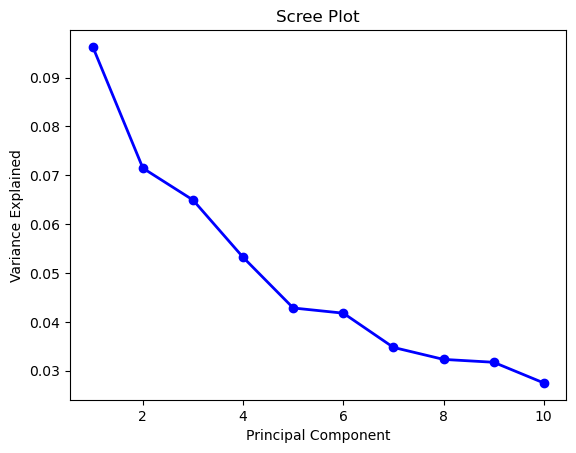

In [13]:
import matplotlib.pyplot as plt
import numpy as np

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

#We will keep 8 elements

In [14]:
# Applying transformation with 7 components
sc = StandardScaler()
pca = PCA(n_components = 7)
embeddings_red = pd.DataFrame(pca.fit_transform(sc.fit_transform(article_embeddings)))
embeddings_red.index = id_list
embeddings_red

,0,1,2,3,4,5,6
article_id,,,,,,,
3,-1.650190,-6.482008,2.065057,5.082789,-3.376445,-2.334764,-1.458678
27,-5.469028,0.475689,-2.766278,3.077006,0.272607,1.899293,0.125664
69,-1.885949,0.773431,5.380948,7.852852,-2.520632,-5.179649,-0.916503
81,-4.331630,-3.230711,2.532907,5.018867,-1.599550,-0.878425,0.334956
84,-8.576104,1.457453,4.241685,6.393900,-1.537113,-4.216184,0.960805
...,...,...,...,...,...,...,...
364017,6.970363,-2.278343,2.121027,2.190397,5.018241,1.564775,2.150588
364022,1.539816,-2.404676,7.392321,7.125041,-0.144020,2.774876,3.275690
364028,5.444127,-4.763036,4.835834,7.220364,1.040424,-5.262566,-1.912335


In [29]:
embeddings_red.reset_index().drop_duplicates()

,article_id,0,1,2,3,4,5,6
0,3,-1.650190,-6.482008,2.065057,5.082789,-3.376445,-2.334764,-1.458678
1,27,-5.469028,0.475689,-2.766278,3.077006,0.272607,1.899293,0.125664
2,69,-1.885949,0.773431,5.380948,7.852852,-2.520632,-5.179649,-0.916503
3,81,-4.331630,-3.230711,2.532907,5.018867,-1.599550,-0.878425,0.334956
4,84,-8.576104,1.457453,4.241685,6.393900,-1.537113,-4.216184,0.960805
...,...,...,...,...,...,...,...,...
46028,364017,6.970363,-2.278343,2.121027,2.190397,5.018241,1.564775,2.150588
46029,364022,1.539816,-2.404676,7.392321,7.125041,-0.144020,2.774876,3.275690
46030,364028,5.444127,-4.763036,4.835834,7.220364,1.040424,-5.262566,-1.912335
46031,364043,1.098170,4.098620,5.454205,-0.087921,14.363914,-2.519454,-1.740445


In [24]:
meta = pd.read_csv('Data/articles_metadata.csv')

meta

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


In [16]:
meta.set_index('article_id', inplace=True)
meta.drop(columns=['created_at_ts'], inplace=True)
meta.head()

,category_id,publisher_id,words_count
article_id,,,
0,0,0,168
1,1,0,189
2,1,0,250
3,1,0,230
4,1,0,162


In [22]:
len(meta)

364047

In [17]:
articles = embeddings_red.merge(meta, left_index=True, right_index=True, how='inner')
articles.index = articles.index.map(lambda x: index_to_hash[x])
for c in ["category_id", "publisher_id", "words_count"]:
    articles[c] = articles[c].astype('int')
articles.head()

,0,1,2,3,4,5,6,category_id,publisher_id,words_count
article_id,,,,,,,,,,
2185194620014831856,-1.650190,-6.482008,2.065057,5.082789,-3.376445,-2.334764,-1.458678,1,0,230
3622748380379877116,-5.469028,0.475689,-2.766278,3.077006,0.272607,1.899293,0.125664,1,0,151
4725800167843106944,-1.885949,0.773431,5.380948,7.852852,-2.520632,-5.179649,-0.916503,1,0,290
10031739448034038636,-4.331630,-3.230711,2.532907,5.018867,-1.599550,-0.878425,0.334956,1,0,202
16394261569950477017,-8.576104,1.457453,4.241685,6.393900,-1.537113,-4.216184,0.960805,1,0,158


In [18]:
for i in range(7):
    articles[i] = articles[i].astype('float64')
articles

,0,1,2,3,4,5,6,category_id,publisher_id,words_count
article_id,,,,,,,,,,
2185194620014831856,-1.650190,-6.482008,2.065057,5.082789,-3.376445,-2.334764,-1.458678,1,0,230
3622748380379877116,-5.469028,0.475689,-2.766278,3.077006,0.272607,1.899293,0.125664,1,0,151
4725800167843106944,-1.885949,0.773431,5.380948,7.852852,-2.520632,-5.179649,-0.916503,1,0,290
10031739448034038636,-4.331630,-3.230711,2.532907,5.018867,-1.599550,-0.878425,0.334956,1,0,202
16394261569950477017,-8.576104,1.457453,4.241685,6.393900,-1.537113,-4.216184,0.960805,1,0,158
...,...,...,...,...,...,...,...,...,...,...
11185703004490003077,6.970363,-2.278343,2.121027,2.190397,5.018241,1.564775,2.150588,458,0,218
13888779676006139336,1.539816,-2.404676,7.392321,7.125041,-0.144020,2.774876,3.275690,460,0,301
11247865369143137341,5.444127,-4.763036,4.835834,7.220364,1.040424,-5.262566,-1.912335,460,0,284


In [30]:
len(articles.index.unique())

46033

### Building the Graph

In [92]:
from graph_builder import *
builder = PandasGraphBuilder()
builder.add_entities(users.reset_index(), 'user_id', 'user')
builder.add_entities(articles.reset_index(), 'article_id', 'article')
builder.add_binary_relations(cf_matrix, 'user_id', 'article_id', 'read')
builder.add_binary_relations(cf_matrix, 'article_id', 'user_id', 'read-by')
g = builder.build()
print(g.number_of_nodes('user'), g.number_of_nodes('article'), g.number_of_edges('read'))

322897 46033 2950710


In [93]:
def linear_normalize(values):
    return (values - values.min(0, keepdims=True)) / (
        values.max(0, keepdims=True) - values.min(0, keepdims=True)
    )

In [94]:
# Assign features.
# Note that this code doesn't work on variable-size features like text or images

user_catcols = ["env", "device", "os", "region", "ref_type"]
user_floatcols = []
article_catcols = ["category_id", "publisher_id"]
article_floatcols = []

for c in users.columns:
    if c in user_catcols:
        users[c] = users[c].astype("category")
        g.nodes["user"].data[c] = torch.LongTensor(
            users[c].cat.codes.values)
    elif users.dtypes[c] == 'float64':
        user_floatcols.append(c)
    else:
        g.nodes["user"].data[c] = torch.LongTensor(users[c].values)
        
g.nodes["user"].data["user_features"] = torch.FloatTensor(
        linear_normalize(users[user_floatcols].to_numpy())
    )

for c in articles.columns:
    if c in article_catcols:
        articles[c] = articles[c].astype("category")
        g.nodes["article"].data[c] = torch.LongTensor(
            articles[c].cat.codes.values
        )
        
    elif articles.dtypes[c] == 'float64':
        article_floatcols.append(c)
    else:
        g.nodes["article"].data[c] = torch.LongTensor(articles[c].values)

# for c in article_floatcols:
#     g.nodes["article"].data[str(c)] = torch.FloatTensor(
#             linear_normalize(articles[[c]].to_numpy())
#         )

g.edges["read"].data["timestamp"] = torch.LongTensor(
    cf_matrix["clicks"].values
)
g.edges["read-by"].data["timestamp"] = torch.LongTensor(
    cf_matrix["clicks"].values
)

print(user_floatcols, article_floatcols)

['avg_session_size'] [0, 1, 2, 3, 4, 5, 6]


In [95]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(cf_matrix, test_size=int(len(cf_matrix)*0.15), shuffle=True)
train_df, val_df = train_test_split(train_df, test_size=int(len(cf_matrix)*0.15), shuffle=True)

print(len(train_df), len(test_df), len(val_df))

2065498 442606 442606


In [96]:
train_indices = list(train_df.index)
test_indices = list(test_df.index)
val_indices = list(val_df.index)

In [97]:
import dgl
import scipy.sparse as ssp
import pickle

def build_train_graph(g, train_indices, utype, itype, etype, etype_rev):
    train_g = g.edge_subgraph({etype: train_indices, etype_rev: train_indices})


#Since DGL update, features are automatically updated
    for ntype in g.ntypes:
        for col, data in g.nodes[ntype].data.items():
            train_g.nodes[ntype].data[col] = data[train_g.nodes[ntype].data[dgl.NID]]
    for etype in g.etypes:
        for col, data in g.edges[etype].data.items():
            train_g.edges[etype].data[col] = data[train_g.edges[etype].data[dgl.EID]]
            
    # remove the induced node IDs - should be assigned by model instead
    del train_g.nodes[utype].data[dgl.NID]
    del train_g.nodes[itype].data[dgl.NID]

    return train_g

def build_val_test_matrix(g, val_indices, test_indices, utype, itype, etype):
    n_users = g.number_of_nodes(utype)
    n_items = g.number_of_nodes(itype)
    val_src, val_dst = g.find_edges(val_indices, etype=etype)
    test_src, test_dst = g.find_edges(test_indices, etype=etype)
    val_src = val_src.numpy()
    val_dst = val_dst.numpy()
    test_src = test_src.numpy()
    test_dst = test_dst.numpy()
    val_matrix = ssp.coo_matrix((np.ones_like(val_src), (val_src, val_dst)), (n_users, n_items))
    test_matrix = ssp.coo_matrix((np.ones_like(test_src), (test_src, test_dst)), (n_users, n_items))

    return val_matrix, test_matrix

In [98]:
train_g = build_train_graph(g, train_indices, "user", "article", "read", "read-by")

In [99]:
val_matrix, test_matrix = build_val_test_matrix(
    g, val_indices, test_indices, "user", "article", "read")

In [100]:

_matrix = val_matrix.tocsr()
_matrix = _matrix.nonzero()
len(_matrix[0])

442606

In [101]:
dgl.save_graphs('data/train_g.bin', train_g)

dataset = {
        "val-matrix": val_matrix,
        "test-matrix": test_matrix,
        "item-texts": {},
        "item-images": None,
        "user-type": "user",
        "item-type": "article",
        "user-to-item-type": "read",
        "item-to-user-type": "read-by",
        "timestamp-edge-column": "timestamp"
    }

with open('data/data.pkl', 'wb') as f:
    pickle.dump(dataset,f)

In [154]:
import argparse

def prec(recommendations, ground_truth, rec_users):
    n_items = ground_truth.shape[1]
    # N_users is the number of users that actually had a recommendation computed
    n_users = len(rec_users)
    K = recommendations.shape[1]
    # Editing user_idx to only take into account recommended users to avoid matrix mismatch
    user_idx = np.repeat(rec_users, K)
    item_idx = recommendations.flatten()
    relevance = ground_truth[user_idx, item_idx].reshape((n_users, K))
    hit = relevance.any(axis=1).mean()
    return hit


class LatestNNRecommender(object):
    def __init__(
        self, user_ntype, item_ntype, user_to_item_etype, timestamp, batch_size
    ):
        self.user_ntype = user_ntype
        self.item_ntype = item_ntype
        self.user_to_item_etype = user_to_item_etype
        self.batch_size = batch_size
        self.timestamp = timestamp

    def recommend(self, full_graph, K, h_user, h_item):
        """
        Return a (n_user, K) matrix of recommended items for each user
        """
        graph_slice = full_graph.edge_type_subgraph([self.user_to_item_etype])
        n_users = full_graph.num_nodes(self.user_ntype)
        latest_interactions = dgl.sampling.select_topk(
            graph_slice, 1, self.timestamp, edge_dir="out"
        )
        user, latest_items = latest_interactions.all_edges(
            form="uv", order="srcdst"
        )
        # each user should have at least one "latest" interaction
        assert torch.equal(user, torch.arange(n_users))

        recommended_batches = []
        
        # Adding an array to count recommended users to avoid matrix mismatch
        rec_users = []
        
        user_batches = torch.arange(n_users).split(self.batch_size)
        for user_batch in user_batches:
            latest_item_batch = latest_items[user_batch].to(
                device=h_item.device
            )
            dist = h_item[latest_item_batch] @ h_item.t()
            # exclude items that are already interacted
            for i, u in enumerate(user_batch.tolist()):
                # This has been modified to add the user to toal_users
                rec_users.append(u)
                interacted_items = full_graph.successors(
                    u, etype=self.user_to_item_etype
                )
                dist[i, interacted_items] = -np.inf
            recommended_batches.append(dist.topk(K, 1)[1])
        recommendations = torch.cat(recommended_batches, 0)
        return recommendations, rec_users


def evaluate_nn(dataset, h_item, k, batch_size):
    g = dataset["train-graph"]
    val_matrix = dataset["val-matrix"].tocsr()
    test_matrix = dataset["test-matrix"].tocsr()
    item_texts = dataset["item-texts"]
    user_ntype = dataset["user-type"]
    item_ntype = dataset["item-type"]
    user_to_item_etype = dataset["user-to-item-type"]
    timestamp = dataset["timestamp-edge-column"]

    rec_engine = LatestNNRecommender(
        user_ntype, item_ntype, user_to_item_etype, timestamp, batch_size
    )

    recommendations, rec_users = rec_engine.recommend(g, k, None, h_item)
    recommendations = recommendations.cpu().numpy()
    return prec(recommendations, val_matrix, rec_users)

In [144]:
import dgl
import dgl.function as fn
import dgl.nn.pytorch as dglnn
import torch
import torch.nn as nn
import torch.nn.functional as F


def disable_grad(module):
    for param in module.parameters():
        param.requires_grad = False


def _init_input_modules(g, ntype, textset, hidden_dims):
    # We initialize the linear projections of each input feature ``x`` as
    # follows:
    # * If ``x`` is a scalar integral feature, we assume that ``x`` is a categorical
    #   feature, and assume the range of ``x`` is 0..max(x).
    # * If ``x`` is a float one-dimensional feature, we assume that ``x`` is a
    #   numeric vector.
    # * If ``x`` is a field of a textset, we process it as bag of words.
    module_dict = nn.ModuleDict()

    for column, data in g.nodes[ntype].data.items():
        if column == dgl.NID:
            continue
        if data.dtype == torch.float32:
            assert data.ndim ==2
            m = nn.Linear(data.shape[0], hidden_dims)
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)
            module_dict[column] = m
        elif data.dtype == torch.int64:
            assert data.ndim == 1
            m = nn.Embedding(data.max() + 2, hidden_dims, padding_idx=-1)
            nn.init.xavier_uniform_(m.weight)
            module_dict[column] = m

    if textset is not None:
        for column, field in textset.items():
            textlist, vocab, pad_var, batch_first = field
            module_dict[column] = BagOfWords(vocab, hidden_dims)

    return module_dict


class BagOfWords(nn.Module):
    def __init__(self, vocab, hidden_dims):
        super().__init__()

        self.emb = nn.Embedding(
            len(vocab.get_itos()),
            hidden_dims,
            padding_idx=vocab.get_stoi()["<pad>"],
        )
        nn.init.xavier_uniform_(self.emb.weight)

    def forward(self, x, length):
        return self.emb(x).sum(1) / length.unsqueeze(1).float()


class LinearProjector(nn.Module):
    """
    Projects each input feature of the graph linearly and sums them up
    """

    def __init__(self, full_graph, ntype, textset, hidden_dims):
        super().__init__()

        self.ntype = ntype
        self.inputs = _init_input_modules(
            full_graph, ntype, textset, hidden_dims
        )

    def forward(self, ndata):
        projections = []
        for feature, data in ndata.items():
            if feature == dgl.NID or feature.endswith("__len"):
                # This is an additional feature indicating the length of the ``feature``
                # column; we shouldn't process this.
                continue

            module = self.inputs[feature]
            if isinstance(module, BagOfWords):
                # Textual feature; find the length and pass it to the textual module.
                length = ndata[feature + "__len"]
                result = module(data, length)
            else:
                result = module(data)
            projections.append(result)

        return torch.stack(projections, 1).sum(1)


class WeightedSAGEConv(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims, act=F.relu):
        super().__init__()

        self.act = act
        self.Q = nn.Linear(input_dims, hidden_dims)
        self.W = nn.Linear(input_dims + hidden_dims, output_dims)
        self.reset_parameters()
        self.dropout = nn.Dropout(0.5)

    def reset_parameters(self):
        gain = nn.init.calculate_gain("relu")
        nn.init.xavier_uniform_(self.Q.weight, gain=gain)
        nn.init.xavier_uniform_(self.W.weight, gain=gain)
        nn.init.constant_(self.Q.bias, 0)
        nn.init.constant_(self.W.bias, 0)

    def forward(self, g, h, weights):
        """
        g : graph
        h : node features
        weights : scalar edge weights
        """
        h_src, h_dst = h
        with g.local_scope():
            g.srcdata["n"] = self.act(self.Q(self.dropout(h_src)))
            g.edata["w"] = weights.float()
            g.update_all(fn.u_mul_e("n", "w", "m"), fn.sum("m", "n"))
            g.update_all(fn.copy_e("w", "m"), fn.sum("m", "ws"))
            n = g.dstdata["n"]
            ws = g.dstdata["ws"].unsqueeze(1).clamp(min=1)
            z = self.act(self.W(self.dropout(torch.cat([n / ws, h_dst], 1))))
            z_norm = z.norm(2, 1, keepdim=True)
            z_norm = torch.where(
                z_norm == 0, torch.tensor(1.0).to(z_norm), z_norm
            )
            z = z / z_norm
            return z


class SAGENet(nn.Module):
    def __init__(self, hidden_dims, n_layers):
        """
        g : DGLGraph
            The user-item interaction graph.
            This is only for finding the range of categorical variables.
        item_textsets : torchtext.data.Dataset
            The textual features of each item node.
        """
        super().__init__()

        self.convs = nn.ModuleList()
        for _ in range(n_layers):
            self.convs.append(
                WeightedSAGEConv(hidden_dims, hidden_dims, hidden_dims)
            )

    def forward(self, blocks, h):
        for layer, block in zip(self.convs, blocks):
            h_dst = h[: block.num_nodes("DST/" + block.ntypes[0])]
            h = layer(block, (h, h_dst), block.edata["weights"])
        return h


class ItemToItemScorer(nn.Module):
    def __init__(self, full_graph, ntype):
        super().__init__()

        n_nodes = full_graph.num_nodes(ntype)
        self.bias = nn.Parameter(torch.zeros(n_nodes, 1))

    def _add_bias(self, edges):
        bias_src = self.bias[edges.src[dgl.NID]]
        bias_dst = self.bias[edges.dst[dgl.NID]]
        return {"s": edges.data["s"] + bias_src + bias_dst}

    def forward(self, item_item_graph, h):
        """
        item_item_graph : graph consists of edges connecting the pairs
        h : hidden state of every node
        """
        with item_item_graph.local_scope():
            item_item_graph.ndata["h"] = h
            item_item_graph.apply_edges(fn.u_dot_v("h", "h", "s"))
            item_item_graph.apply_edges(self._add_bias)
            pair_score = item_item_graph.edata["s"]
        return pair_score

In [145]:
import dgl
import numpy as np
import torch
from torch.utils.data import DataLoader, IterableDataset
from torchtext.data.functional import numericalize_tokens_from_iterator


def padding(array, yy, val):
    """
    :param array: torch tensor array
    :param yy: desired width
    :param val: padded value
    :return: padded array
    """
    w = array.shape[0]
    b = 0
    bb = yy - b - w

    return torch.nn.functional.pad(
        array, pad=(b, bb), mode="constant", value=val
    )


def compact_and_copy(frontier, seeds):
    block = dgl.to_block(frontier, seeds)
    for col, data in frontier.edata.items():
        if col == dgl.EID:
            continue
        block.edata[col] = data[block.edata[dgl.EID]]
    return block


class ItemToItemBatchSampler(IterableDataset):
    def __init__(self, g, user_type, item_type, batch_size):
        self.g = g
        self.user_type = user_type
        self.item_type = item_type
        self.user_to_item_etype = list(g.metagraph()[user_type][item_type])[0]
        self.item_to_user_etype = list(g.metagraph()[item_type][user_type])[0]
        self.batch_size = batch_size

    def __iter__(self):
        while True:
            heads = torch.randint(
                0, self.g.num_nodes(self.item_type), (self.batch_size,)
            )
            tails = dgl.sampling.random_walk(
                self.g,
                heads,
                metapath=[self.item_to_user_etype, self.user_to_item_etype],
            )[0][:, 2]
            neg_tails = torch.randint(
                0, self.g.num_nodes(self.item_type), (self.batch_size,)
            )

            mask = tails != -1
            yield heads[mask], tails[mask], neg_tails[mask]


class NeighborSampler(object):
    def __init__(
        self,
        g,
        user_type,
        item_type,
        random_walk_length,
        random_walk_restart_prob,
        num_random_walks,
        num_neighbors,
        num_layers,
    ):
        self.g = g
        self.user_type = user_type
        self.item_type = item_type
        self.user_to_item_etype = list(g.metagraph()[user_type][item_type])[0]
        self.item_to_user_etype = list(g.metagraph()[item_type][user_type])[0]
        self.samplers = [
            dgl.sampling.PinSAGESampler(
                g,
                item_type,
                user_type,
                random_walk_length,
                random_walk_restart_prob,
                num_random_walks,
                num_neighbors,
            )
            for _ in range(num_layers)
        ]

    def sample_blocks(self, seeds, heads=None, tails=None, neg_tails=None):
        blocks = []
        for sampler in self.samplers:
            frontier = sampler(seeds)
            if heads is not None:
                eids = frontier.edge_ids(
                    torch.cat([heads, heads]),
                    torch.cat([tails, neg_tails]),
                    return_uv=True,
                )[2]
                if len(eids) > 0:
                    old_frontier = frontier
                    frontier = dgl.remove_edges(old_frontier, eids)
                    # print(old_frontier)
                    # print(frontier)
                    # print(frontier.edata['weights'])
                    # frontier.edata['weights'] = old_frontier.edata['weights'][frontier.edata[dgl.EID]]
            block = compact_and_copy(frontier, seeds)
            seeds = block.srcdata[dgl.NID]
            blocks.insert(0, block)
        return blocks

    def sample_from_item_pairs(self, heads, tails, neg_tails):
        # Create a graph with positive connections only and another graph with negative
        # connections only.
        pos_graph = dgl.graph(
            (heads, tails), num_nodes=self.g.num_nodes(self.item_type)
        )
        neg_graph = dgl.graph(
            (heads, neg_tails), num_nodes=self.g.num_nodes(self.item_type)
        )
        pos_graph, neg_graph = dgl.compact_graphs([pos_graph, neg_graph])
        seeds = pos_graph.ndata[dgl.NID]

        blocks = self.sample_blocks(seeds, heads, tails, neg_tails)
        return pos_graph, neg_graph, blocks


def assign_simple_node_features(ndata, g, ntype, assign_id=False):
    """
    Copies data to the given block from the corresponding nodes in the original graph.
    """
    for col in g.nodes[ntype].data.keys():
        if not assign_id and col == dgl.NID:
            continue
        induced_nodes = ndata[dgl.NID]
        ndata[col] = g.nodes[ntype].data[col][induced_nodes]


def assign_textual_node_features(ndata, textset, ntype):
    """
    Assigns numericalized tokens from a torchtext dataset to given block.
    The numericalized tokens would be stored in the block as node features
    with the same name as ``field_name``.
    The length would be stored as another node feature with name
    ``field_name + '__len'``.
    block : DGLGraph
        First element of the compacted blocks, with "dgl.NID" as the
        corresponding node ID in the original graph, hence the index to the
        text dataset.
        The numericalized tokens (and lengths if available) would be stored
        onto the blocks as new node features.
    textset : torchtext.data.Dataset
        A torchtext dataset whose number of examples is the same as that
        of nodes in the original graph.
    """
    node_ids = ndata[dgl.NID].numpy()

    for field_name, field in textset.items():
        textlist, vocab, pad_var, batch_first = field

        examples = [textlist[i] for i in node_ids]
        ids_iter = numericalize_tokens_from_iterator(vocab, examples)

        maxsize = max([len(textlist[i]) for i in node_ids])
        ids = next(ids_iter)
        x = torch.asarray([num for num in ids])
        lengths = torch.tensor([len(x)])
        tokens = padding(x, maxsize, pad_var)

        for ids in ids_iter:
            x = torch.asarray([num for num in ids])
            l = torch.tensor([len(x)])
            y = padding(x, maxsize, pad_var)
            tokens = torch.vstack((tokens, y))
            lengths = torch.cat((lengths, l))

        if not batch_first:
            tokens = tokens.t()

        ndata[field_name] = tokens
        ndata[field_name + "__len"] = lengths


def assign_features_to_blocks(blocks, g, textset, ntype):
    # For the first block (which is closest to the input), copy the features from
    # the original graph as well as the texts.
    assign_simple_node_features(blocks[0].srcdata, g, ntype)
    assign_textual_node_features(blocks[0].srcdata, textset, ntype)
    assign_simple_node_features(blocks[-1].dstdata, g, ntype)
    assign_textual_node_features(blocks[-1].dstdata, textset, ntype)


class PinSAGECollator(object):
    def __init__(self, sampler, g, ntype, textset):
        self.sampler = sampler
        self.ntype = ntype
        self.g = g
        self.textset = textset

    def collate_train(self, batches):
        heads, tails, neg_tails = batches[0]
        # Construct multilayer neighborhood via PinSAGE...
        pos_graph, neg_graph, blocks = self.sampler.sample_from_item_pairs(
            heads, tails, neg_tails
        )
        assign_features_to_blocks(blocks, self.g, self.textset, self.ntype)

        return pos_graph, neg_graph, blocks

    def collate_test(self, samples):
        batch = torch.LongTensor(samples)
        blocks = self.sampler.sample_blocks(batch)
        assign_features_to_blocks(blocks, self.g, self.textset, self.ntype)
        return blocks

In [146]:
import numpy as np
import torch
import torch.nn as nn
import torchtext
import tqdm
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


class PinSAGEModel(nn.Module):
    def __init__(self, full_graph, ntype, textsets, hidden_dims, n_layers):
        super().__init__()

        self.proj = LinearProjector(
            full_graph, ntype, textsets, hidden_dims
        )
        self.sage = SAGENet(hidden_dims, n_layers)
        self.scorer = ItemToItemScorer(full_graph, ntype)

    def forward(self, pos_graph, neg_graph, blocks):
        h_item = self.get_repr(blocks)
        pos_score = self.scorer(pos_graph, h_item)
        neg_score = self.scorer(neg_graph, h_item)
        return (neg_score - pos_score + 1).clamp(min=0)

    def get_repr(self, blocks):
        h_item = self.proj(blocks[0].srcdata)
        h_item_dst = self.proj(blocks[-1].dstdata)
        return h_item_dst + self.sage(blocks, h_item)


def train(dataset, args):
    g = dataset["train-graph"]
    val_matrix = dataset["val-matrix"].tocsr()
    test_matrix = dataset["test-matrix"].tocsr()
    item_texts = dataset["item-texts"]
    user_ntype = dataset["user-type"]
    item_ntype = dataset["item-type"]
    user_to_item_etype = dataset["user-to-item-type"]
    timestamp = dataset["timestamp-edge-column"]

    device = torch.device(args.device)

    # Assign user and movie IDs and use them as features (to learn an individual trainable
    # embedding for each entity)
    g.nodes[user_ntype].data["id"] = torch.arange(g.num_nodes(user_ntype))
    g.nodes[item_ntype].data["id"] = torch.arange(g.num_nodes(item_ntype))

    # Prepare torchtext dataset and Vocabulary
    textset = {}
    tokenizer = get_tokenizer(None)

    textlist = []
    batch_first = True

    for i in range(g.num_nodes(item_ntype)):
        for key in item_texts.keys():
            l = tokenizer(item_texts[key][i].lower())
            textlist.append(l)
    for key, field in item_texts.items():
        vocab2 = build_vocab_from_iterator(
            textlist, specials=["<unk>", "<pad>"]
        )
        textset[key] = (
            textlist,
            vocab2,
            vocab2.get_stoi()["<pad>"],
            batch_first,
        )

    # Sampler
    batch_sampler = ItemToItemBatchSampler(
        g, user_ntype, item_ntype, args.batch_size
    )
    neighbor_sampler = NeighborSampler(
        g,
        user_ntype,
        item_ntype,
        args.random_walk_length,
        args.random_walk_restart_prob,
        args.num_random_walks,
        args.num_neighbors,
        args.num_layers,
    )
    collator = PinSAGECollator(
        neighbor_sampler, g, item_ntype, textset
    )
    dataloader = DataLoader(
        batch_sampler,
        collate_fn=collator.collate_train,
        num_workers=args.num_workers,
    )
    dataloader_test = DataLoader(
        torch.arange(g.num_nodes(item_ntype)),
        batch_size=args.batch_size,
        collate_fn=collator.collate_test,
        num_workers=args.num_workers,
    )
    dataloader_it = iter(dataloader)

    # Model
    model = PinSAGEModel(
        g, item_ntype, textset, args.hidden_dims, args.num_layers
    ).to(device)
    # Optimizer
    opt = torch.optim.Adam(model.parameters(), lr=args.lr)

    # For each batch of head-tail-negative triplets...
    for epoch_id in range(args.num_epochs):
        model.train()
        for batch_id in tqdm.trange(args.batches_per_epoch):
            pos_graph, neg_graph, blocks = next(dataloader_it)
            # Copy to GPU
            for i in range(len(blocks)):
                blocks[i] = blocks[i].to(device)
            pos_graph = pos_graph.to(device)
            neg_graph = neg_graph.to(device)

            loss = model(pos_graph, neg_graph, blocks).mean()
            opt.zero_grad()
            loss.backward()
            opt.step()

        # Evaluate
        model.eval()
        with torch.no_grad():
            item_batches = torch.arange(g.num_nodes(item_ntype)).split(
                args.batch_size
            )
            h_item_batches = []
            for blocks in dataloader_test:
                for i in range(len(blocks)):
                    blocks[i] = blocks[i].to(device)

                h_item_batches.append(model.get_repr(blocks))
            h_item = torch.cat(h_item_batches, 0)

            print(
                evaluate_nn(dataset, h_item, args.k, args.batch_size)
            )
            
    return model


In [147]:
model = PinSAGEModel(
        train_g, 'article', None, args.hidden_dims, args.num_layers
    ).to(args.device)

batch_sampler = ItemToItemBatchSampler(
    train_g, 'user', 'article', 32
)

neighbor_sampler = NeighborSampler(
    train_g,
    'user',
    'article',
    2,
    0.5,
    10,
    3,
    2,
)
collator = PinSAGECollator(
    neighbor_sampler, train_g, 'user', {}
)
dataloader = DataLoader(
    batch_sampler,
    collate_fn=collator.collate_train,
    num_workers=args.num_workers,
)

dataloader_it = iter(dataloader)

In [148]:
dataset["train-graph"] = train_g

In [149]:
import json
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
with open('config/args.json', 'rb') as file:
    args = dotdict(json.load(file))

In [162]:
args.batch_size = 32
args.hidden_dims = 64
args.batches_per_epoch = 6000
args.num_workers = 0
args

{'random_walk_length': 2,
 'random_walk_restart_prob': 0.5,
 'num_random_walks': 10,
 'num_neighbors': 3,
 'num_layers': 2,
 'hidden_dims': 64,
 'batch_size': 32,
 'device': 'cuda:0',
 'num_epochs': 50,
 'batches_per_epoch': 6000,
 'num_workers': 0,
 'lr': 3e-05,
 'k': 10}

In [164]:
trained_model = train(dataset, args)

100%|████████████████| 6000/6000 [02:00<00:00, 49.66it/s]


5.435112746618241e-05


100%|████████████████| 6000/6000 [02:04<00:00, 48.23it/s]


1.918275087041732e-05


100%|████████████████| 6000/6000 [02:02<00:00, 49.15it/s]


3.516837659576509e-05


100%|████████████████| 6000/6000 [02:04<00:00, 48.23it/s]


5.115400232111286e-05


100%|████████████████| 6000/6000 [02:05<00:00, 47.63it/s]


4.79568771760433e-05


100%|████████████████| 6000/6000 [02:06<00:00, 47.58it/s]


5.435112746618241e-05


100%|████████████████| 6000/6000 [02:04<00:00, 48.31it/s]


6.074537775632152e-05


100%|████████████████| 6000/6000 [02:03<00:00, 48.40it/s]


5.115400232111286e-05


100%|████████████████| 6000/6000 [02:02<00:00, 49.01it/s]


4.79568771760433e-05


100%|████████████████| 6000/6000 [02:02<00:00, 48.93it/s]


6.394250290139107e-05


100%|████████████████| 6000/6000 [02:02<00:00, 48.94it/s]


4.79568771760433e-05


100%|████████████████| 6000/6000 [02:09<00:00, 46.18it/s]


5.435112746618241e-05


100%|████████████████| 6000/6000 [02:03<00:00, 48.55it/s]


4.79568771760433e-05


100%|████████████████| 6000/6000 [02:09<00:00, 46.17it/s]


5.115400232111286e-05


100%|████████████████| 6000/6000 [02:03<00:00, 48.48it/s]


6.713962804646062e-05


100%|████████████████| 6000/6000 [02:05<00:00, 47.79it/s]


5.435112746618241e-05


100%|████████████████| 6000/6000 [02:02<00:00, 49.05it/s]


7.033675319153018e-05


100%|████████████████| 6000/6000 [02:02<00:00, 48.82it/s]


7.033675319153018e-05


100%|████████████████| 6000/6000 [02:00<00:00, 49.85it/s]


5.754825261125196e-05


100%|████████████████| 6000/6000 [02:01<00:00, 49.53it/s]


7.353387833659973e-05


100%|████████████████| 6000/6000 [02:00<00:00, 50.00it/s]


6.713962804646062e-05


100%|████████████████| 6000/6000 [02:00<00:00, 49.94it/s]


7.353387833659973e-05


100%|████████████████| 6000/6000 [02:00<00:00, 49.76it/s]


4.79568771760433e-05


100%|████████████████| 6000/6000 [02:03<00:00, 48.75it/s]


7.673100348166928e-05


100%|████████████████| 6000/6000 [02:03<00:00, 48.46it/s]


7.673100348166928e-05


100%|████████████████| 6000/6000 [02:04<00:00, 48.27it/s]


5.435112746618241e-05


100%|████████████████| 6000/6000 [02:07<00:00, 47.00it/s]


7.033675319153018e-05


100%|████████████████| 6000/6000 [02:02<00:00, 49.08it/s]


6.394250290139107e-05


100%|████████████████| 6000/6000 [02:05<00:00, 47.62it/s]


6.713962804646062e-05


100%|████████████████| 6000/6000 [02:06<00:00, 47.61it/s]


5.115400232111286e-05


100%|████████████████| 6000/6000 [02:00<00:00, 49.94it/s]


4.4759752030973745e-05


100%|████████████████| 6000/6000 [02:01<00:00, 49.55it/s]


5.435112746618241e-05


100%|████████████████| 6000/6000 [02:01<00:00, 49.22it/s]


6.713962804646062e-05


100%|████████████████| 6000/6000 [01:59<00:00, 50.14it/s]


5.754825261125196e-05


100%|████████████████| 6000/6000 [02:00<00:00, 49.86it/s]


7.033675319153018e-05


100%|████████████████| 6000/6000 [02:00<00:00, 49.99it/s]


7.353387833659973e-05


100%|████████████████| 6000/6000 [01:59<00:00, 50.18it/s]


4.79568771760433e-05


100%|████████████████| 6000/6000 [01:59<00:00, 50.10it/s]


5.435112746618241e-05


100%|████████████████| 6000/6000 [02:01<00:00, 49.56it/s]


4.79568771760433e-05


100%|████████████████| 6000/6000 [02:00<00:00, 49.67it/s]


5.435112746618241e-05


100%|████████████████| 6000/6000 [01:59<00:00, 50.31it/s]


4.79568771760433e-05


100%|████████████████| 6000/6000 [01:57<00:00, 50.94it/s]


4.79568771760433e-05


100%|████████████████| 6000/6000 [01:57<00:00, 51.10it/s]


4.79568771760433e-05


100%|████████████████| 6000/6000 [01:57<00:00, 51.07it/s]


6.074537775632152e-05


100%|████████████████| 6000/6000 [01:58<00:00, 50.60it/s]


5.435112746618241e-05


100%|████████████████| 6000/6000 [02:02<00:00, 49.14it/s]


5.115400232111286e-05


100%|████████████████| 6000/6000 [01:57<00:00, 51.06it/s]


5.754825261125196e-05


100%|████████████████| 6000/6000 [01:57<00:00, 51.00it/s]


4.79568771760433e-05


100%|████████████████| 6000/6000 [01:57<00:00, 51.06it/s]


6.074537775632152e-05


100%|████████████████| 6000/6000 [02:01<00:00, 49.56it/s]


7.353387833659973e-05


In [170]:
model = model.to(args.device)


In [174]:
pos_graph, neg_graph, blocks = next(dataloader_it)

In [175]:
outputs = model(pos_graph, neg_graph, blocks)

KeyError: 'clicks'